In [27]:
import numpy as np
from mountain import *
import matplotlib.pyplot as plt


In [28]:
# env = Mountain_one()

Run policy evaluation straight left to right

In [29]:
env = Mountain_one()
ROWS, COLS = env.get_map().shape

def straight_policy(order="rtl", gamma = 1):
    V = np.zeros((ROWS, COLS))

    if order == "rtl":      # right -> left
        col_range = range(COLS-1, -1, -1)
    else:                   # left -> right
        col_range = range(COLS)

    for j in col_range:
        for i in range(ROWS):

            if j == COLS-1:   # terminal column
                continue

            s = (i, j)
            a = "forward"

            next_s = env.next_state(s, a)
            r = env.get_reward(s, a)

            V[s] = r + gamma * V[next_s]

    return V


V_rtl = straight_policy("rtl")
V_ltr_1 = straight_policy("ltr")

print("RTL after 1 sweep:\n", V_rtl[0][0])
print("LTR after 1 sweep:\n", V_ltr_1[0][0])

RTL after 1 sweep:
 -67.43137399
LTR after 1 sweep:
 -0.7843138


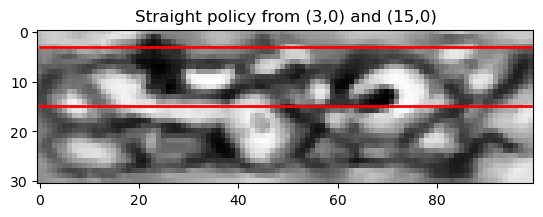

In [30]:
terrain = env.get_map()

plt.imshow(terrain, cmap='gray')
plt.title("Straight policy from (3,0) and (15,0)")

# trajectory coordinates
start_row = 15
cols = list(range(COLS))
rows_1 = [15] * COLS
rows_2 = [3] * COLS


plt.plot(cols, rows_1, color='red', linewidth=2)
plt.plot(cols, rows_2, color='red', linewidth=2)

plt.show()

Task 7

In [31]:
starting_pos = []
for row in range(ROWS):
    starting_pos.append(float(V_rtl_1[row][0]))
print("starting positions:", starting_pos)
best_start = max(starting_pos)
print(f"The best value startpos: {best_start}, row: {starting_pos.index(best_start)}")


starting positions: [-67.43137399, -61.658825500000006, -56.384315619999995, -52.796080069999995, -49.129413629999995, -43.83921732999998, -37.35294258499998, -35.72156986299999, -43.27843296699998, -49.34902137899999, -51.376472048999986, -49.17647173200002, -45.356863945, -48.21176585100001, -54.945099794, -57.80784459, -60.39215865999999, -60.69019825, -52.48235468000001, -44.72549154000001, -41.91372676999999, -42.4627465, -44.909805005, -45.25882518499999, -45.027452619999984, -42.85882514499999, -38.482354210000004, -38.00392276, -45.564707059999975, -54.09804133999999, -60.38431538]
The best value startpos: -35.72156986299999, row: 7


Task 8

In [32]:
def random_policy_evaluation(gamma=1.0, theta=1e-6):
    V = np.zeros((ROWS, COLS))

    while True:
        delta = 0

        for j in range(COLS-1, -1, -1):
            for i in range(ROWS):

                if j == COLS-1:
                    continue

                s = (i, j)

                new_v = 0
                for a in env.actions:  # expectation over actions
                    next_s = env.next_state(s, a)
                    r = env.get_reward(s, a)
                    new_v += (1/3) * (r + gamma * V[next_s])

                delta = max(delta, abs(new_v - V[s]))
                V[s] = new_v

        if delta < theta:
            break

    return V

General policy evaluation with order parameter

In [33]:
V_random = random_policy_evaluation()
print(V_random[0])

[-54.30150797 -53.66434371 -53.00697767 -52.34010895 -51.66879199
 -51.01779835 -50.39915222 -49.809516   -49.24980814 -48.67570061
 -48.0660267  -47.43810975 -46.83599706 -46.25435774 -45.66021543
 -45.02671835 -44.38387878 -43.74617838 -43.1091853  -42.50381621
 -42.03852573 -41.67102099 -41.38627559 -41.15267807 -40.87171848
 -40.50714609 -40.10738583 -39.68359673 -39.24521494 -38.79858348
 -38.33621934 -37.8584827  -37.33929726 -36.76845437 -36.15599162
 -35.51887107 -34.87336415 -34.2297034  -33.60630825 -33.0068288
 -32.44819373 -31.93187423 -31.43796415 -30.98640777 -30.60292462
 -30.25078796 -29.86794839 -29.3962414  -28.9304544  -28.52637216
 -28.12234909 -27.69562484 -27.23721101 -26.75609196 -26.2795501
 -25.80640712 -25.32823088 -24.84721162 -24.36641526 -23.87830436
 -23.36523743 -22.81301996 -22.23413525 -21.63121993 -21.01046542
 -20.37613125 -19.73785887 -19.0883297  -18.42690715 -17.75295165
 -17.06736528 -16.37618112 -15.69495821 -15.02859508 -14.39488082
 -13.7888260

Find a trajectory starting at a given state.

In [34]:
def sample_random_trajectory(start):
    trajectory = [start]
    s = start

    while s[1] < COLS-1:   # until last column
        a = np.random.choice(env.actions)
        s = env.next_state(s, a)
        trajectory.append(s)

    return trajectory

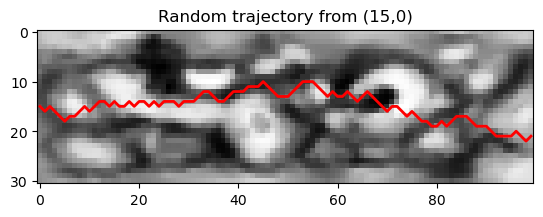

In [35]:
traj = sample_random_trajectory((15,0))

rows = [s[0] for s in traj]
cols = [s[1] for s in traj]

plt.imshow(env.get_map(), cmap="gray", origin="upper")
plt.plot(cols, rows, color="red", linewidth=2)

plt.title("Random trajectory from (15,0)")
plt.show()

Compare straight policy (0,15), (0, 3) and random policy (0, 15):

In [ ]:
str_15_0 = V_rtl[3][0]
str_3_0 = V_rtl[15][0]
rng_15_0 = V_random[15][0]

print(f"Straight policy value at (15,0): {str_15_0}")
print(f"Straight policy value at (3,0): {str_3_0}")
print(f"Random policy value at (15,0): {rng_15_0}")

Straight policy value at (15,0): -52.796080069999995
Straight policy value at (3,0): -57.80784459
Random policy value at (15,0): -51.30835471835944


Trying to learn an optimal policy. Implement an algorithm for policy iteration:
Start from πrnd; find an optimal policy using standard policy iteration where you alternate: (i) policy evaluation until the state values are stable (they change less than a ε threshold).

In [ ]:
# policy = np.random.choice(env.actions, size=(ROWS, COLS))

In [43]:
def evaluate_policy(policy, V, gamma=1.0, theta=1e-4):

    while True:
        delta = 0

        for j in range(COLS-1, -1, -1):
            for i in range(ROWS):

                if j == COLS-1:
                    continue

                s = (i, j)
                a = policy[s]

                next_s = env.next_state(s, a)
                r = env.get_reward(s, a)

                new_v = r + gamma * V[next_s]

                delta = max(delta, abs(new_v - V[s]))
                V[s] = new_v

        if delta < theta:
            break

    return V

Policy improvement:

In [44]:
def improve_policy(policy, V, gamma=1.0):
    policy_stable = True
    new_policy = np.empty((ROWS, COLS), dtype=object)

    for j in range(COLS-1, -1, -1):
        for i in range(ROWS):

            if j == COLS-1:
                continue

            s = (i, j)
            old_action = policy[s]

            best_a = None
            best_value = -np.inf

            for a in env.actions:
                next_s = env.next_state(s, a)
                r = env.get_reward(s, a)
                val = r + gamma * V[next_s]

                if val > best_value:
                    best_value = val
                    best_a = a

            new_policy[s] = best_a

            if old_action != best_a:
                policy_stable = False

    return new_policy, policy_stable

Combine the two:

In [45]:
def policy_iteration(gamma=1.0, theta=1e-4):

    policy = np.random.choice(env.actions, size=(ROWS, COLS))
    V = np.zeros((ROWS, COLS))

    while True:

        V = evaluate_policy(policy, V, gamma, theta)

        new_policy, stable = improve_policy(policy, V, gamma)

        policy = new_policy

        if stable:
            break

    return policy, V

In [46]:
improved_policy, V_learn = policy_iteration()

Follow policy

In [48]:
def follow_policy(policy, start=(15,0)):
    trajectory = [start]
    s = start

    while s[1] < COLS-1:        # until terminal column
        a = policy[s]           # ← use learned action
        s = env.next_state(s, a)
        trajectory.append(s)

    return trajectory

In [52]:
best_row = np.argmax(V_learn[:,0])
print("Best starting row:", best_row)

Best starting row: 9


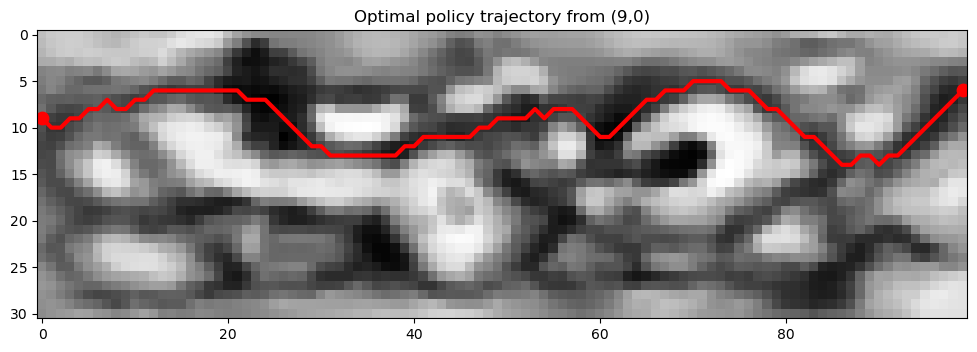

In [58]:
traj = follow_policy(improved_policy, (best_row,0))

# convert to plottable coordinates
ys = [s[0] for s in traj]
xs = [s[1] for s in traj]

plt.figure(figsize=(12,4))
plt.imshow(env.get_map(), cmap="gray", origin="upper")

plt.plot(xs, ys, color="red", linewidth=3)   # draw path
plt.scatter(xs[0], ys[0], s=80, c="r") # start
plt.scatter(xs[-1], ys[-1], s=80, c="r") # goal

plt.title(f"Optimal policy trajectory from ({best_row},0)")
plt.show()

15.
Always start from πrnd; find an optimal policy using truncated policy iteration where you alternate: (i) k = 3 steps of policy evaluation; and, (ii) policy improvement.

In [59]:
def truncated_evaluate_policy(policy, gamma=1.0, k=3):
    V = np.zeros((ROWS, COLS))

    for _ in range(k):  # ONLY k iterations
        for j in range(COLS-1, -1, -1):
            for i in range(ROWS):

                if j == COLS-1:
                    continue

                s = (i, j)
                a = policy[s]

                next_s = env.next_state(s, a)
                r = env.get_reward(s, a)

                V[s] = r + gamma * V[next_s]

    return V

In [60]:
def truncated_policy_iteration(gamma=1.0, k=3):

    # start from random policy
    policy = np.random.choice(env.actions, size=(ROWS, COLS))

    while True:

        # (i) truncated evaluation
        V = truncated_evaluate_policy(policy, gamma, k)

        # (ii) improvement
        new_policy, stable = improve_policy(policy, V, gamma)

        policy = new_policy

        if stable:
            break

    return policy, V

In [61]:
tpi_policy, tpi_V = truncated_policy_iteration()

In [62]:
best_row_trunc = np.argmax(V_learn[:,0])
print("Best starting row:", best_row_trunc)

Best starting row: 9


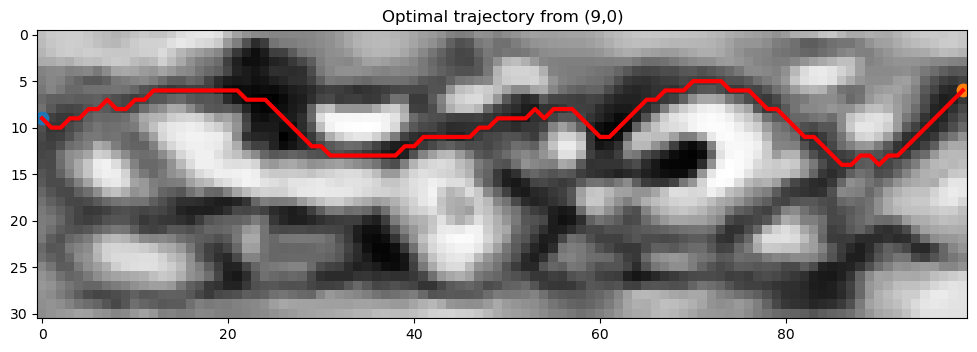

In [65]:
traj = follow_policy(tpi_policy, (best_row_trunc,0))

ys = [s[0] for s in traj]
xs = [s[1] for s in traj]

plt.figure(figsize=(12,4))
plt.imshow(env.get_map(), cmap="gray", origin="upper")

plt.plot(xs, ys, linewidth=3, color="red")
plt.scatter(xs[0], ys[0], s=80)
plt.scatter(xs[-1], ys[-1], s=80)

plt.title(f"Optimal trajectory from ({best_row_trunc},0)")
plt.show()

In [66]:
def greedy_policy_from_V(V, gamma=1.0):
    policy = np.empty((ROWS, COLS), dtype=object)

    for j in range(COLS-1, -1, -1):
        for i in range(ROWS):
            if j == COLS-1:
                policy[(i, j)] = "forward"  # arbitrary at terminal
                continue

            s = (i, j)
            best_a, best_q = None, -np.inf
            for a in env.actions:
                s_next = env.next_state(s, a)
                r = env.get_reward(s, a)
                q = r + gamma * V[s_next]
                if q > best_q:
                    best_q, best_a = q, a
            policy[s] = best_a

    return policy

In [67]:
def one_sweep_policy_eval(policy, V, gamma=1.0):
    # one Gauss–Seidel sweep (rtl) for V^pi
    for j in range(COLS-1, -1, -1):
        for i in range(ROWS):
            if j == COLS-1:
                continue
            s = (i, j)
            a = policy[s]
            s_next = env.next_state(s, a)
            r = env.get_reward(s, a)
            V[s] = r + gamma * V[s_next]
    return V


def value_iteration_as_k1_TPI(gamma=1.0, theta=1e-4, max_iters=10_000):
    policy = np.random.choice(env.actions, size=(ROWS, COLS))  # πrnd start
    V = np.zeros((ROWS, COLS))

    for _ in range(max_iters):
        V_old = V.copy()

        # (i) k=1 eval step under current policy
        V = one_sweep_policy_eval(policy, V, gamma)

        # (ii) improve
        policy = greedy_policy_from_V(V, gamma)

        # stop when values stop changing (or you can stop on policy stability)
        if np.max(np.abs(V - V_old)) < theta:
            break

    return policy, V

In [68]:
def value_iteration_bellman(gamma=1.0, theta=1e-4, max_iters=10_000):
    V = np.zeros((ROWS, COLS))

    for _ in range(max_iters):
        delta = 0

        for j in range(COLS-1, -1, -1):
            for i in range(ROWS):
                if j == COLS-1:
                    continue

                s = (i, j)
                best_q = -np.inf

                for a in env.actions:
                    s_next = env.next_state(s, a)
                    r = env.get_reward(s, a)
                    q = r + gamma * V[s_next]
                    if q > best_q:
                        best_q = q

                delta = max(delta, abs(best_q - V[s]))
                V[s] = best_q

        if delta < theta:
            break

    policy = greedy_policy_from_V(V, gamma)
    return policy, V

In [ ]:
vi_policy, vi_V = value_iteration_bellman(gamma=1.0, theta=1e-4)

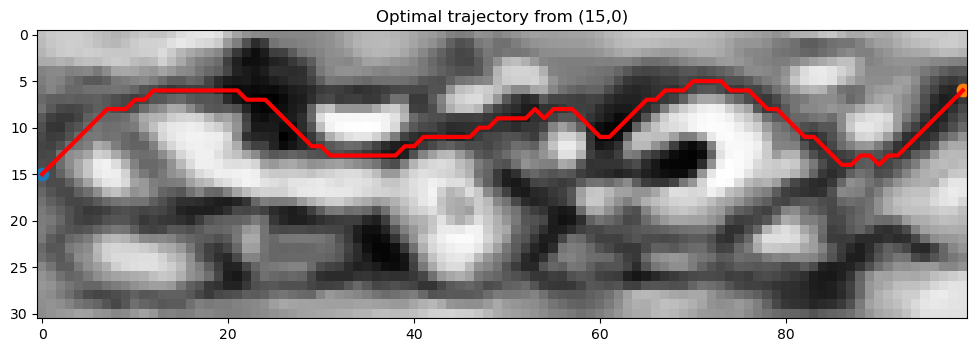

In [71]:
traj = follow_policy(vi_policy, (15,0))

ys = [s[0] for s in traj]
xs = [s[1] for s in traj]

plt.figure(figsize=(12,4))
plt.imshow(env.get_map(), cmap="gray", origin="upper")

plt.plot(xs, ys, linewidth=3, color="red")
plt.scatter(xs[0], ys[0], s=80)
plt.scatter(xs[-1], ys[-1], s=80)

plt.title(f"Optimal trajectory from (15,0)")
plt.show()

In [72]:
import time

t0 = time.perf_counter()
vi_policy, vi_V = value_iteration_bellman(gamma=1.0, theta=1e-4)
print("VI:", time.perf_counter() - t0)

t0 = time.perf_counter()
pi_policy, pi_V = policy_iteration(gamma=1.0, theta=1e-4)
print("PI:", time.perf_counter() - t0)

t0 = time.perf_counter()
tpi_policy, tpi_V = truncated_policy_iteration(gamma=1.0, k=3)
print("TPI:", time.perf_counter() - t0)

VI: 0.057011600001715124
PI: 0.26619200001005083
TPI: 0.4121347999898717
